In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('Alzheimer_s Dataset')):
    subfolder_path = os.path.join('Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 29.80it/s]


,image,label
0,Alzheimer_s Dataset\test\MildDemented\26 (19).jpg,MildDemented
1,Alzheimer_s Dataset\test\MildDemented\26 (20).jpg,MildDemented
2,Alzheimer_s Dataset\test\MildDemented\26 (21).jpg,MildDemented
3,Alzheimer_s Dataset\test\MildDemented\26 (22).jpg,MildDemented
4,Alzheimer_s Dataset\test\MildDemented\26 (23).jpg,MildDemented
...,...,...
6395,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6396,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6397,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented
6398,Alzheimer_s Dataset\train\VeryMildDemented\ver...,VeryMildDemented


In [3]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

for i in range(len(train_data_gen)):
    train_data, train_labels = train_data_gen[i]

Found 6400 validated image filenames belonging to 4 classes.


In [4]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [5]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [6]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]

In [7]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


In [8]:
def create_cnn_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, padding='same', activation='relu', input_shape=(176,176,3)),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Conv2D(128, kernel_size=(3,3), strides=2, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

In [9]:
# Instantiate multiple instances of the CNN model
num_models = 4
cnn_models = [create_cnn_model() for _ in range(num_models)]

checkpoint_cb = ModelCheckpoint("model_{epoch:02d}.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

C:\Users\085\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=model_{epoch:02d}.h5

In [ ]:
# Train each CNN model and save them
for i, model in enumerate(cnn_models):
    print(f"Training and saving CNN Model {i+1}/{num_models}")
    # Train the model...
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(X_train,y_train, epochs=30, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])
    # Save the model
    model.save(f"model_{i+1}.h5")

Training and saving CNN Model 1/4
Epoch 1/30
280/280 [==============================] - 11s 17ms/step - loss: 0.8631 - accuracy: 0.5811 - val_loss: 0.5861 - val_accuracy: 0.7302
Epoch 2/30
280/280 [==============================] - 3s 12ms/step - loss: 0.4551 - accuracy: 0.7970 - val_loss: 0.3576 - val_accuracy: 0.8594
Epoch 3/30
280/280 [==============================] - 3s 12ms/step - loss: 0.2494 - accuracy: 0.8960 - val_loss: 0.2311 - val_accuracy: 0.9062
Epoch 4/30
280/280 [==============================] - 3s 12ms/step - loss: 0.1531 - accuracy: 0.9410 - val_loss: 0.1548 - val_accuracy: 0.9365
Epoch 5/30
280/280 [==============================] - 3s 12ms/step - loss: 0.0968 - accuracy: 0.9650 - val_loss: 0.1751 - val_accuracy: 0.9292
Epoch 6/30
280/280 [==============================] - 3s 12ms/step - loss: 0.0672 - accuracy: 0.9751 - val_loss: 0.0870 - val_accuracy: 0.9698
Epoch 7/30
280/280 [==============================] - 3s 12ms/step - loss: 0.0607 - accuracy: 0.9785 - val_

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.856115,0.588393,0.545400,0.741667
1,0.428806,0.810603,0.369910,0.834375
2,0.230920,0.903683,0.185362,0.930208
3,0.140570,0.945312,0.131197,0.951563
4,0.085418,0.967522,0.085910,0.966667
5,0.051855,0.981808,0.083822,0.966667
6,0.045193,0.983147,0.084124,0.971875
7,0.039047,0.986942,0.099305,0.967708
8,0.036403,0.985714,0.105878,0.963021
9,0.027416,0.990737,0.119155,0.963542


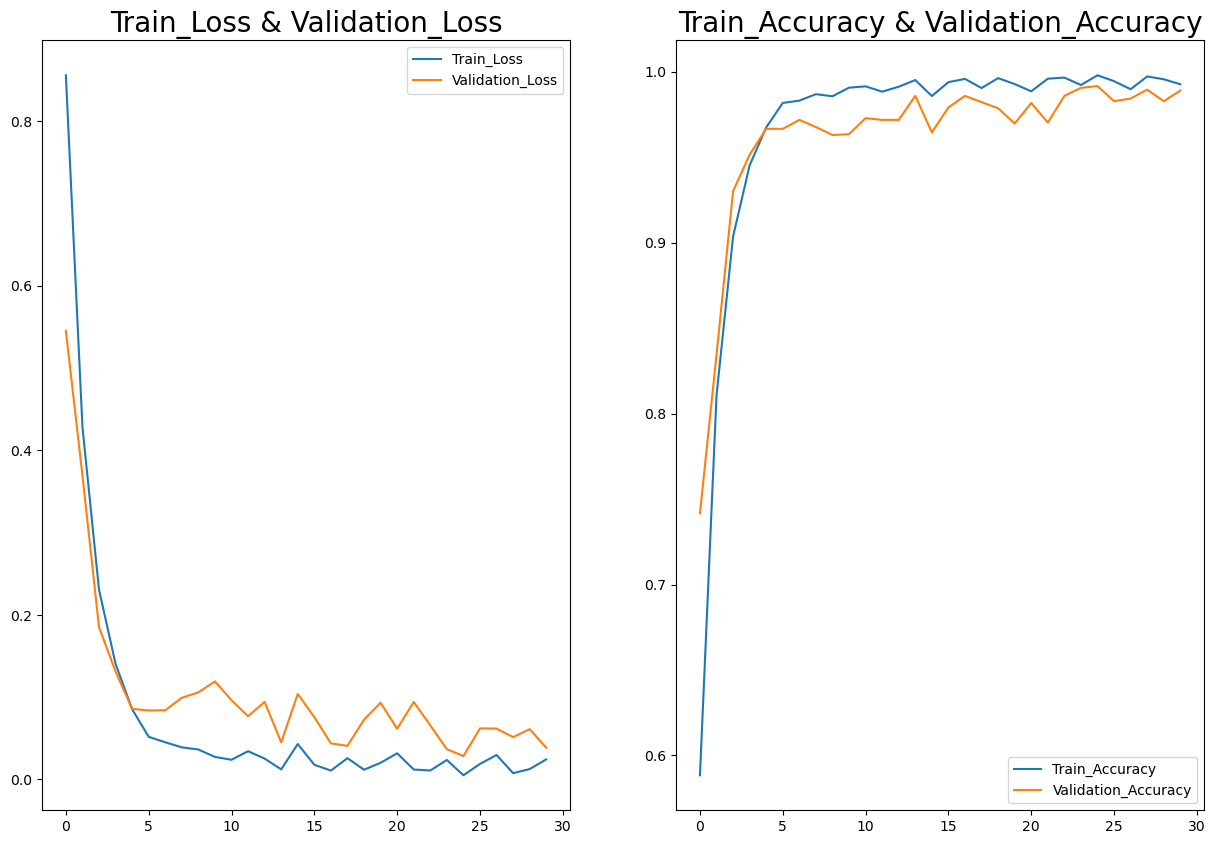

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 0s 7ms/step - loss: 0.0289 - accuracy: 0.9906
Test Loss = 0.028933044523000717
Test Accuracy = 0.9906250238418579


In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 1s 7ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,0
3,2,2
4,2,2
...,...,...
1915,2,2
1916,0,0
1917,2,2
1918,3,3


array([[473,   0,   3,   4],
       [  0, 480,   0,   0],
       [  1,   0, 473,   6],
       [  1,   0,   3, 476]])

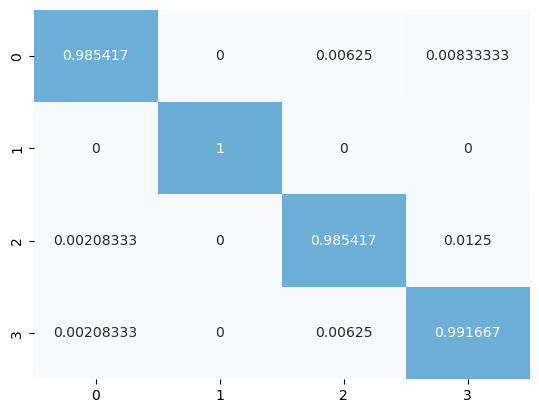

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      0.99      0.99       480
           1       1.00      1.00      1.00       480
           2       0.99      0.99      0.99       480
           3       0.98      0.99      0.99       480

    accuracy                           0.99      1920
   macro avg       0.99      0.99      0.99      1920
weighted avg       0.99      0.99      0.99      1920



In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define function to prepare image
def prepare_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load the image
    img_array = img_to_array(img)  # Convert the image to numpy array
    img_array = img_array / 255.0  # Scale the image (if your model requires normalization)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Load saved models
models = []
for i in range(1, 5):
    model_path = f"model_{i}.h5"
    model = keras.models.load_model(model_path)
    models.append(model)

# Define image path
image_path = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg"

# Prepare the image
prepared_image = prepare_image(image_path, target_size=(176, 176))

# Predict using each model
predictions = [model.predict(prepared_image) for model in models]

# Combine predictions
ensemble_prediction = np.mean(predictions, axis=0)
predicted_class = np.argmax(ensemble_prediction, axis=1)  # Get the class with highest probability

# Output the result
class_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
predicted_class_label = class_labels[predicted_class[0]]
print(f"Predicted Class: {predicted_class_label}")

1/1 [==============================] - 0s 76ms/step
Predicted Class: NonDemented


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the function to create a MobileNet model
def create_mobilenet_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers on top of MobileNet
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')
    ])
    
    return model

# Instantiate multiple instances of the MobileNet model
num_models = 4
mobilenet_models = [create_mobilenet_model() for _ in range(num_models)]

checkpoint_cb = ModelCheckpoint("model_mobilenet{epoch:02d}.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Train each MobileNet model and save them
for i, model in enumerate(mobilenet_models):
    print(f"Training and saving MobileNet Model {i+1}/{num_models}")
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # Train the model
    hist = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])
    # Save the model
    model.save(f"mobilenet_model_{i+1}.h5")




Training and saving MobileNet Model 1/4

Epoch 1/30


280/280 [==============================] - ETA: 0s - loss: 0.9183 - accuracy: 0.6379

C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 97s 337ms/step - loss: 0.9183 - accuracy: 0.6379 - val_loss: 0.6107 - val_accuracy: 0.7318
Epoch 2/30
280/280 [==============================] - 91s 326ms/step - loss: 0.5709 - accuracy: 0.7493 - val_loss: 0.5054 - val_accuracy: 0.7781
Epoch 3/30
280/280 [==============================] - 92s 329ms/step - loss: 0.4911 - accuracy: 0.7869 - val_loss: 0.4446 - val_accuracy: 0.8094
Epoch 4/30
280/280 [==============================] - 100s 358ms/step - loss: 0.4417 - accuracy: 0.8092 - val_loss: 0.4048 - val_accuracy: 0.8318
Epoch 5/30
280/280 [==============================] - 99s 353ms/step - loss: 0.4045 - accuracy: 0.8316 - val_loss: 0.3844 - val_accuracy: 0.8391
Epoch 6/30
280/280 [==============================] - 99s 354ms/step - loss: 0.3653 - accuracy: 0.8461 - val_loss: 0.3500 - val_accuracy: 0.8448
Epoch 7/30
280/280 [==============================] - 99s 353ms/step - loss: 0.3380 - accuracy: 0.8575 - val_loss: 0.3225 - val_accuracy: 0.

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.916802,0.634040,0.656023,0.699479
1,0.576181,0.742299,0.609257,0.726562
2,0.497366,0.780692,0.526074,0.773438
3,0.456138,0.800670,0.433374,0.817708
4,0.405825,0.829911,0.375255,0.840104
5,0.372983,0.841183,0.366262,0.847917
6,0.322942,0.866853,0.347486,0.856771
7,0.297618,0.877902,0.333326,0.863542
8,0.284144,0.883371,0.328013,0.862500
9,0.260244,0.892076,0.266921,0.894792


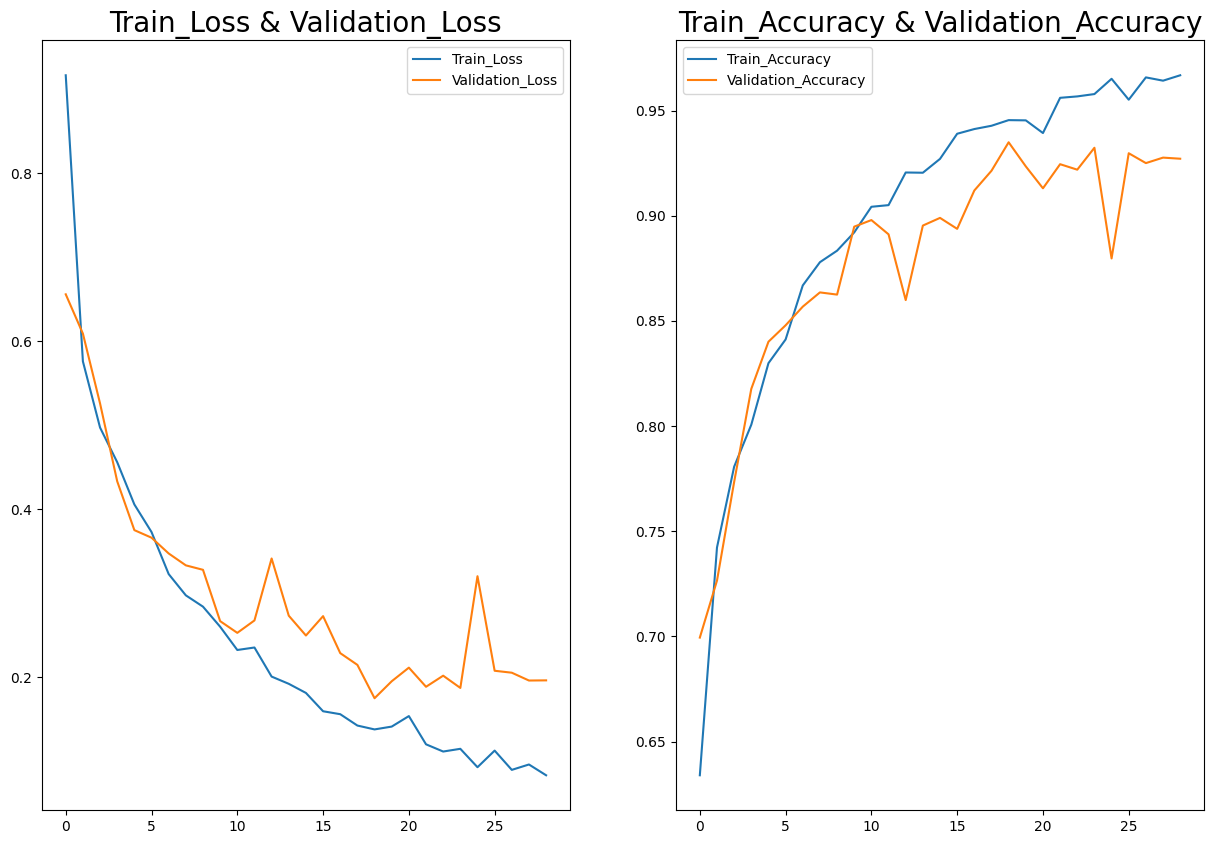

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 17s 283ms/step - loss: 0.1774 - accuracy: 0.9323
Test Loss = 0.17739436030387878
Test Accuracy = 0.9322916865348816


In [ ]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 18s 285ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,0
3,2,2
4,2,2
...,...,...
1915,2,2
1916,0,0
1917,2,2
1918,3,3


array([[464,   0,   6,  10],
       [  0, 480,   0,   0],
       [  5,   0, 442,  33],
       [  6,   0,  70, 404]], dtype=int64)

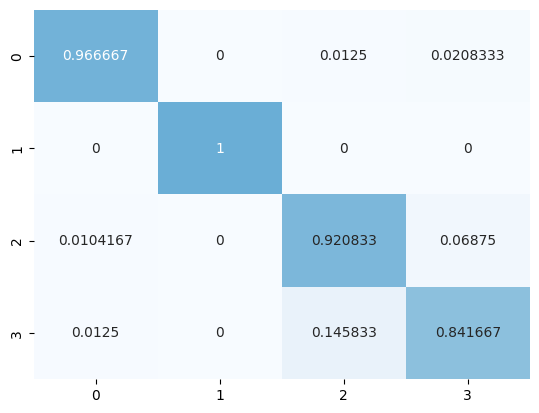

In [ ]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.98      0.97      0.97       480
           1       1.00      1.00      1.00       480
           2       0.85      0.92      0.89       480
           3       0.90      0.84      0.87       480

    accuracy                           0.93      1920
   macro avg       0.93      0.93      0.93      1920
weighted avg       0.93      0.93      0.93      1920

